In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [111]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)


Sheet names: ['收盘价', '自由流通换手率']


In [112]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [113]:
# 查看前5行
print(df.head())

  Unnamed: 0     50收益  中证1000全收益     800收益
0 2005-01-04  835.130    989.984  983.8953
1 2005-01-05  839.529   1013.583  995.5764
2 2005-01-06  830.513   1005.466  986.2162
3 2005-01-07  831.641   1011.740  987.6929
4 2005-01-10  841.102   1023.638  997.1864


In [114]:
# 检查数据类型与缺失值情况
print(df.info())
print("Missing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4974 entries, 0 to 4973
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  4974 non-null   datetime64[ns]
 1   50收益        4974 non-null   float64       
 2   中证1000全收益   4974 non-null   float64       
 3   800收益       4974 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 155.6 KB
None
Missing values:
 Unnamed: 0    0
50收益          0
中证1000全收益     0
800收益         0
dtype: int64


In [115]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


In [116]:
# 计算月度收益率

# 使用 resample('M') 提取每月最后一个交易日收盘价
monthly_prices = df.resample('M').last()

# 计算 simple return（当月相对上月涨幅）
monthly_returns = monthly_prices.pct_change()

monthly_returns

C:\Users\Loki\AppData\Local\Temp\ipykernel_960\1653378666.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()


,50收益,中证1000全收益,800收益
date,,,
2005-01-31,NaN,NaN,NaN
2005-02-28,0.067751,0.113851,0.094154
2005-03-31,-0.084268,-0.144244,-0.102051
2005-04-30,-0.006853,-0.088453,-0.022693
2005-05-31,-0.068857,-0.031163,-0.075721
...,...,...,...
2025-02-28,0.021406,0.072599,0.026608
2025-03-31,0.010109,-0.006961,-0.000559
2025-04-30,-0.011117,-0.044030,-0.031148


## 1. 动态配置

In [127]:
# 设定滚动区间（单位：月）
lookback_window = 36

# 配置比例范围（大盘配置比例，小盘=1-大盘）
weights = np.arange(0.1, 1.0, 0.1)

# 记录结果
results = []

# 从 lookback_window 月份后开始回测
for i in range(lookback_window, len(monthly_returns)):
    # 定义回看区间
    window_data = monthly_returns.iloc[i-lookback_window:i]
    
    # 计算各配置比例在回看期内的平均收益率
    avg_returns = []
    for w in weights:
        # 大盘收益 * 大盘权重 + 小盘收益 * 小盘权重
        combined = window_data.iloc[:,0] * w + window_data.iloc[:,1] * (1-w)
        avg_returns.append(combined.mean())
    
    # 选择平均收益率最高的配置
    max_idx = np.argmax(avg_returns)
    best_weight = weights[max_idx]
    
    # 应用于下个月
    next_month_return = monthly_returns.iloc[i,0]*best_weight + monthly_returns.iloc[i,1]*(1-best_weight)
    
    # 保存结果
    results.append({
        'date': monthly_returns.index[i],
        'best_weight': best_weight,
        'next_month_return': next_month_return
    })

# 转为 DataFrame
results_df = pd.DataFrame(results).set_index('date')

# 计算累计收益率
results_df['cum_return'] = (1 + results_df['next_month_return']).cumprod()

# 查看结果
print(results_df.head())


            best_weight  next_month_return  cum_return
date                                                  
2008-01-31          0.1          -0.072986    0.927014
2008-02-29          0.1           0.091337    1.011684
2008-03-31          0.1          -0.170669    0.839021
2008-04-30          0.1          -0.053641    0.794015
2008-05-31          0.1          -0.029383    0.770685


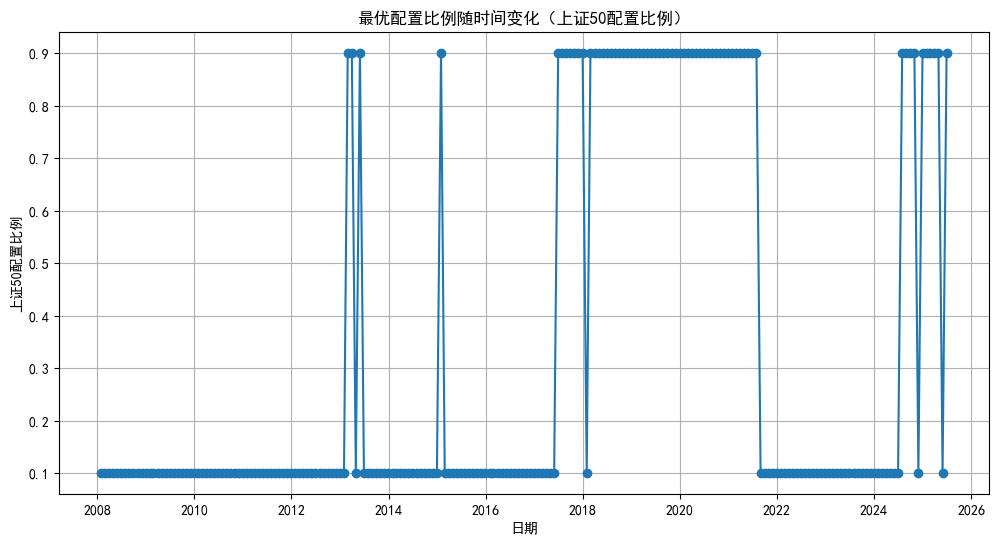

In [128]:
plt.figure(figsize=(12,6))
plt.plot(results_df.index, results_df['best_weight'], marker='o', linestyle='-')
plt.title('最优配置比例随时间变化（上证50配置比例）')
plt.xlabel('日期')
plt.ylabel('上证50配置比例')
plt.grid(True)
plt.show()

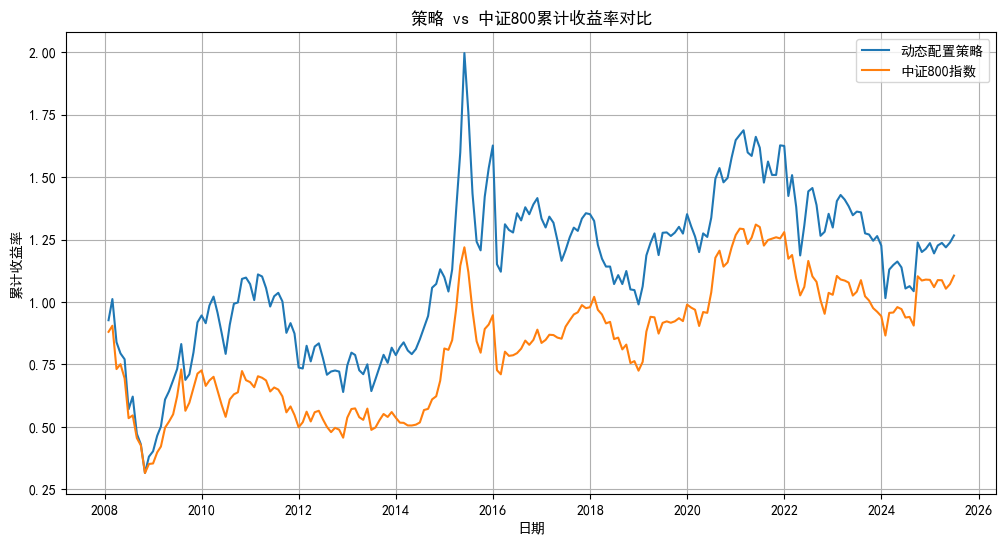

In [125]:
# 计算中证800的累计收益率
csi800_returns = monthly_returns.iloc[lookback_window:, 2]  
csi800_cum_return = (1 + csi800_returns).cumprod()
csi800_cum_return.index = results_df.index  

# 绘图
plt.figure(figsize=(12,6))
plt.plot(results_df.index, results_df['cum_return'], label='动态配置策略')
plt.plot(results_df.index, csi800_cum_return, label='中证800指数')
plt.title('策略 vs 中证800累计收益率对比')
plt.xlabel('日期')
plt.ylabel('累计收益率')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
def backtest_dynamic_strategy(monthly_returns, lookback_window, start_date=None, end_date=None, weights=np.arange(0.1,1.0,0.1)):
    results = []

    # 筛选日期范围
    if start_date:
        monthly_returns = monthly_returns[monthly_returns.index >= start_date]
    if end_date:
        monthly_returns = monthly_returns[monthly_returns.index <= end_date]

    for i in range(lookback_window, len(monthly_returns)):
        window_data = monthly_returns.iloc[i-lookback_window:i]
        
        avg_returns = []
        for w in weights:
            combined = window_data.iloc[:,0] * w + window_data.iloc[:,1] * (1-w)
            avg_returns.append(combined.mean())
        
        max_idx = np.argmax(avg_returns)
        best_weight = weights[max_idx]
        
        next_month_return = monthly_returns.iloc[i,0]*best_weight + monthly_returns.iloc[i,1]*(1-best_weight)
        
        results.append({
            'date': monthly_returns.index[i],
            'best_weight': best_weight,
            'next_month_return': next_month_return
        })
    
    results_df = pd.DataFrame(results).set_index('date')
    results_df['cum_return'] = (1 + results_df['next_month_return']).cumprod()
    
    return results_df


In [27]:
def calculate_performance(strategy_returns, benchmark_returns):
    # 确保输入为 numpy array
    strat_r = np.array(strategy_returns)
    bench_r = np.array(benchmark_returns)
    
    # 超额收益
    excess_r = strat_r - bench_r
    
    # 年化收益率
    ann_ret = (np.prod(1 + strat_r)) ** (12 / len(strat_r)) - 1
    
    # 年化波动率
    ann_vol = np.std(strat_r) * np.sqrt(12)
    
    # 夏普比率
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    
    # 最大回撤
    cum = np.cumprod(1 + strat_r)
    peak = np.maximum.accumulate(cum)
    max_drawdown = np.max((peak - cum) / peak)
    
    # 超额净值（策略累计净值 / 基准累计净值）
    cum_strategy = np.cumprod(1 + strat_r)[-1]
    cum_benchmark = np.cumprod(1 + bench_r)[-1]
    excess_nav = cum_strategy / cum_benchmark
    
    return ann_ret, ann_vol, sharpe, max_drawdown, excess_nav

In [49]:
# 训练集回测，用于参数调优
train_start = '2005-01-01'
train_end = monthly_returns.index[-1]

lookback_windows = [12, 36, 60]
train_results = {}
first_dates = []

# 先运行所有回测，记录各策略起点
for lw in lookback_windows:
    res_df = backtest_dynamic_strategy(monthly_returns, lw, start_date=train_start, end_date=train_end)
    train_results[lw] = res_df
    first_dates.append(res_df.index[0])

# 统一比较区间起点 = 所有策略最晚的起点
compare_start = max(first_dates)
print(f"统一比较起点: {compare_start}")

# 准备输出表格
performance_table = []

# 计算各策略绩效
for lw in lookback_windows:
    df = train_results[lw]
    
    # 截取统一比较区间
    df = df[df.index >= compare_start]
    
    # 策略收益
    strat_returns = df['next_month_return']
    
    # 对应基准收益
    bench_returns = monthly_returns.loc[df.index, monthly_returns.columns[2]]
    
    # 确保长度一致
    min_len = min(len(strat_returns), len(bench_returns))
    strat_returns = strat_returns[:min_len]
    bench_returns = bench_returns[:min_len]
    
    # 计算绩效
    ann_ret, ann_vol, sharpe, max_drawdown, excess_nav = calculate_performance(strat_returns, bench_returns)
    
    performance_table.append({
        'lookback_window': lw,
        'annual_return': ann_ret,
        'annual_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'excess_nav': excess_nav
    })

# 转为 DataFrame 方便查看
perf_df = pd.DataFrame(performance_table)
print(perf_df.sort_values(by='excess_nav', ascending=False))

统一比较起点: 2010-01-31 00:00:00
   lookback_window  annual_return  annual_volatility  sharpe_ratio  \
2               60       0.031978           0.256176      0.124829   
0               12       0.028312           0.232096      0.121985   
1               36       0.018985           0.254029      0.074734   

   max_drawdown  excess_nav  
2      0.580709    1.070271  
0      0.485298    1.012834  
1      0.503993    0.879425  


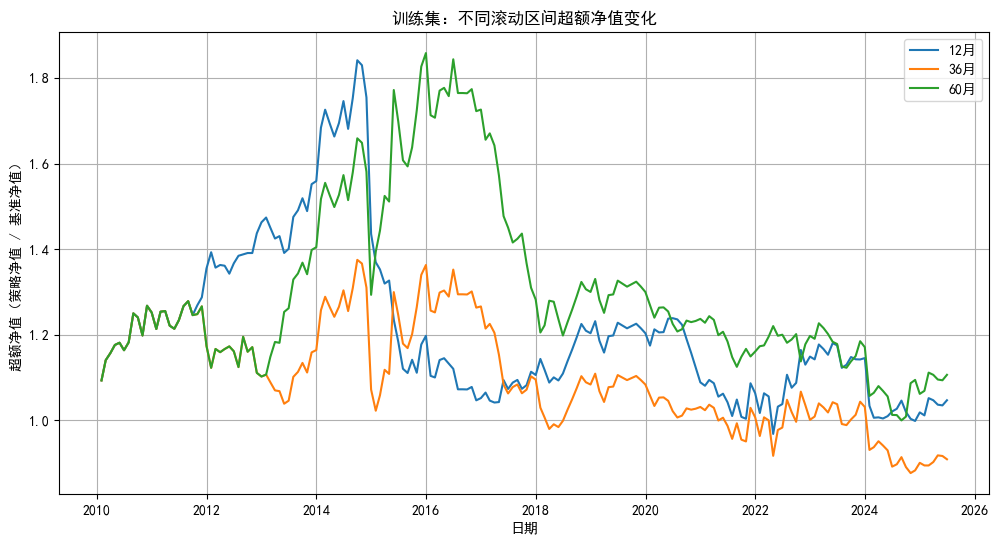

In [ ]:
plt.figure(figsize=(12,6))

for lw in lookback_windows:
    df = train_results[lw]
    df = df[df.index >= compare_start]
    
    strat_cum = df['cum_return']
    
    # 获取对应的基准净值
    bench_returns = monthly_returns.loc[df.index, monthly_returns.columns[2]]
    bench_cum = (1 + bench_returns).cumprod()
    
    # 归一化策略净值
    strat_cum_norm = strat_cum.values / strat_cum.values[0]
    
    # 计算超额净值 = 策略净值 / 基准净值
    excess_nav_series = strat_cum_norm / bench_cum.values
    
    plt.plot(df.index, excess_nav_series, label=f'{lw}月')

plt.title('不同滚动区间超额净值变化')
plt.xlabel('日期')
plt.ylabel('超额净值（策略净值 / 基准净值）')
plt.legend()
plt.grid(True)
plt.show()


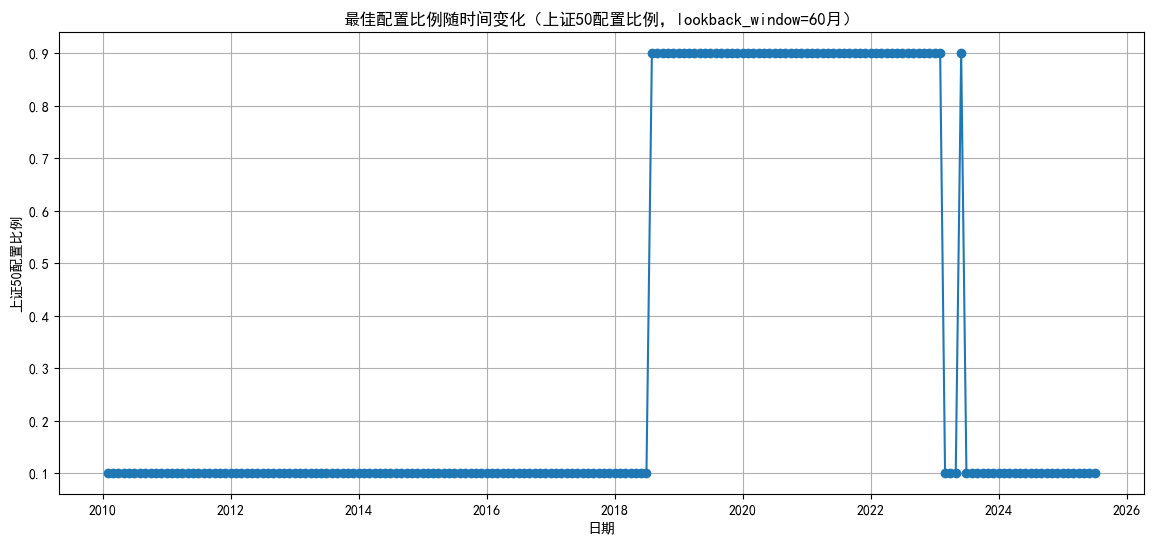

In [52]:
# 使用最佳 lookback window 回测全数据
best_lw = 60
final_result = backtest_dynamic_strategy(
    monthly_returns,
    best_lw,
    start_date=monthly_returns.index[0],
    end_date=monthly_returns.index[-1]
)

# 绘制配置比例（上证50配置比例 = best_weight）
plt.figure(figsize=(14,6))
plt.plot(final_result.index, final_result['best_weight'], marker='o', linestyle='-')
plt.title(f'最佳配置比例随时间变化（上证50配置比例，lookback_window={best_lw}月）')
plt.xlabel('日期')
plt.ylabel('上证50配置比例')
plt.grid(True)
plt.show()

## 基础分析

### 单变量分析

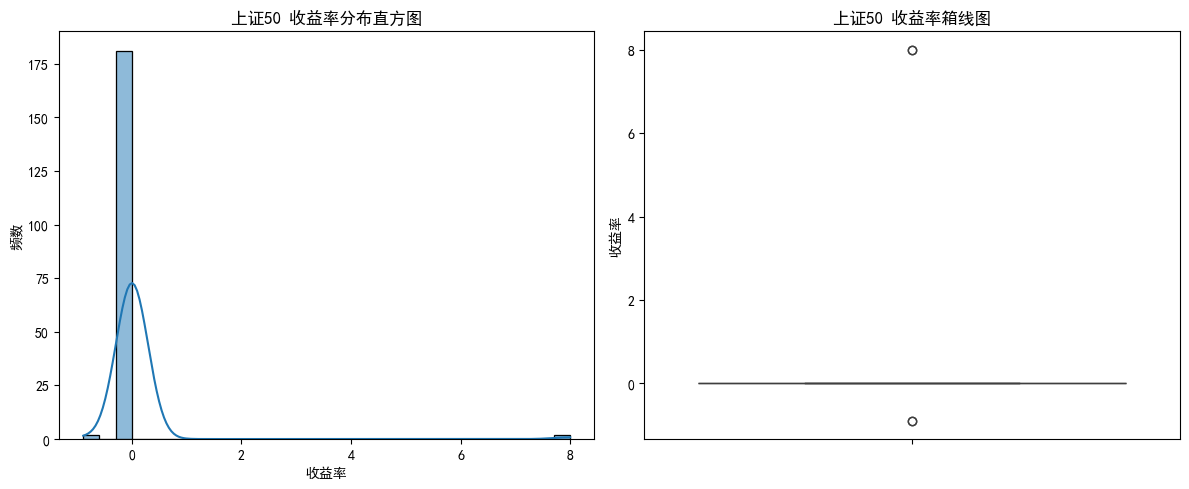

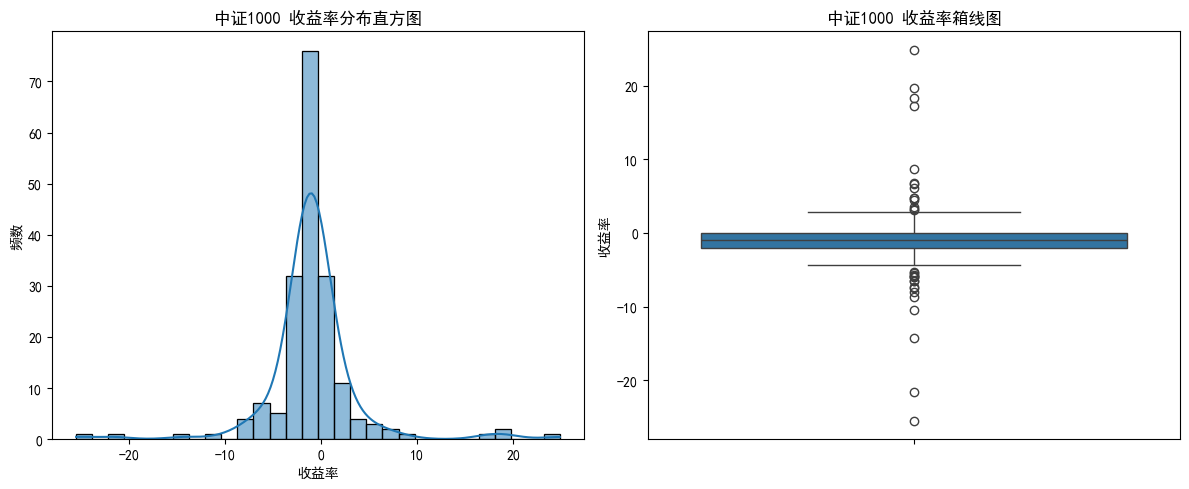

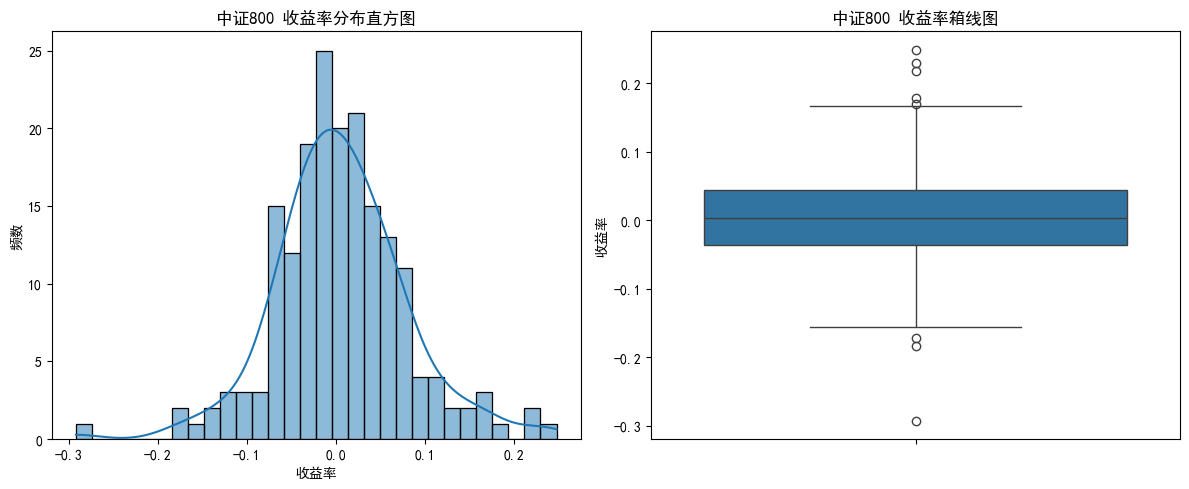

In [55]:
# 计算各指数收益率
returns = df.pct_change().dropna()
returns.columns = ['上证50', '中证1000', '中证800']

# 绘制直方图 + 箱线图
for col in returns.columns:
    plt.figure(figsize=(12,5))
    
    # 直方图
    plt.subplot(1,2,1)
    sns.histplot(returns[col], kde=True, bins=30)
    plt.title(f"{col} 收益率分布直方图")
    plt.xlabel("收益率")
    plt.ylabel("频数")
    
    # 箱线图
    plt.subplot(1,2,2)
    sns.boxplot(y=returns[col])
    plt.title(f"{col} 收益率箱线图")
    plt.ylabel("收益率")
    
    plt.tight_layout()
    plt.show()

### 双变量/跨变量分析

相关性

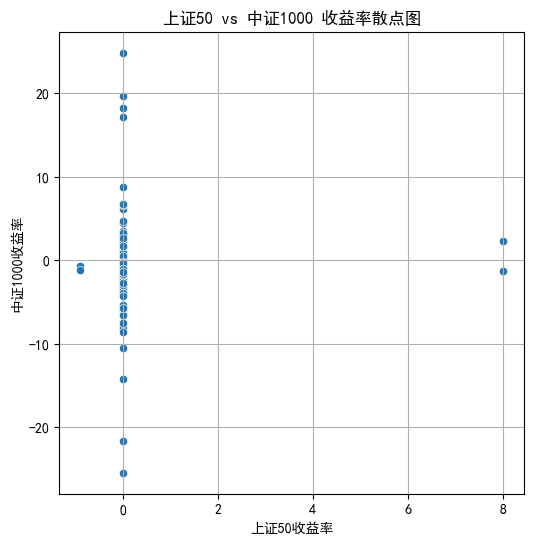

Pearson 相关系数: 0.0306
Spearman 相关系数: 0.0365


In [57]:
# 提取大盘、小盘
large = returns['上证50']
small = returns['中证1000']

# 绘制散点图
plt.figure(figsize=(6,6))
sns.scatterplot(x=large, y=small)
plt.xlabel('上证50收益率')
plt.ylabel('中证1000收益率')
plt.title('上证50 vs 中证1000 收益率散点图')
plt.grid(True)
plt.show()

# 计算 Pearson & Spearman 相关系数
pearson_corr = large.corr(small)
spearman_corr, _ = spearmanr(large, small)

print(f"Pearson 相关系数: {pearson_corr:.4f}")
print(f"Spearman 相关系数: {spearman_corr:.4f}")

超额收益率分析

超额收益率描述统计：
count    185.000000
mean       0.986221
std        4.820360
min      -24.839240
25%        0.072356
50%        0.959532
75%        2.212245
max       25.479030
dtype: float64
偏度 (skewness): -0.6147
峰度 (kurtosis): 12.5161


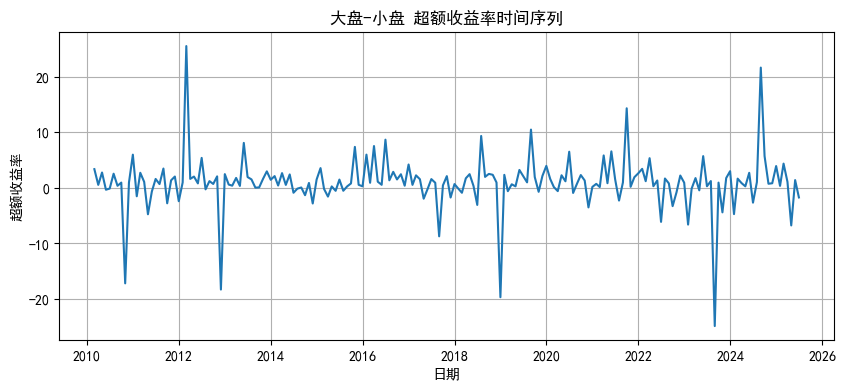

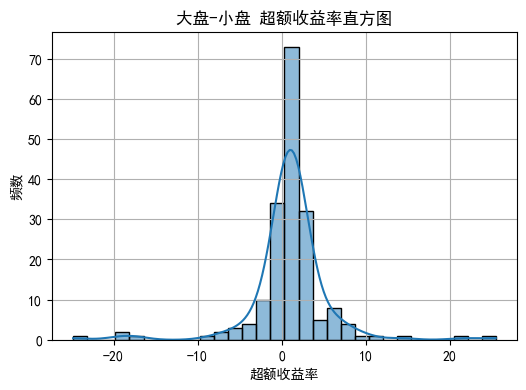

In [58]:
# 计算超额收益率（大盘 - 小盘）
excess = large - small

# 描述统计
desc = excess.describe()
skewness = excess.skew()
kurtosis = excess.kurtosis()

print("超额收益率描述统计：")
print(desc)
print(f"偏度 (skewness): {skewness:.4f}")
print(f"峰度 (kurtosis): {kurtosis:.4f}")

# 绘制时间序列
plt.figure(figsize=(10,4))
plt.plot(excess.index, excess)
plt.title('大盘-小盘 超额收益率时间序列')
plt.xlabel('日期')
plt.ylabel('超额收益率')
plt.grid(True)
plt.show()

# 绘制直方图
plt.figure(figsize=(6,4))
sns.histplot(excess, kde=True, bins=30)
plt.title('大盘-小盘 超额收益率直方图')
plt.xlabel('超额收益率')
plt.ylabel('频数')
plt.grid(True)
plt.show()

滞后自相关

<Figure size 800x400 with 0 Axes>

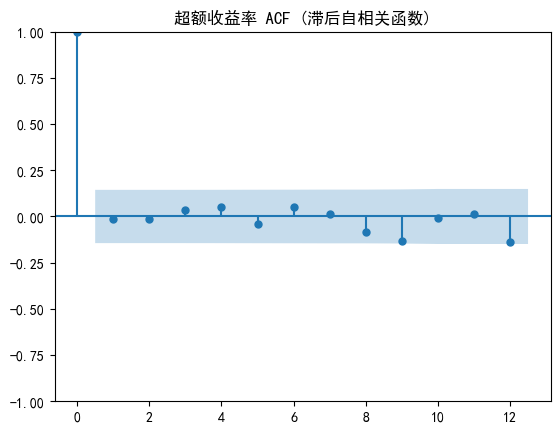

In [60]:
# 绘制 ACF
plt.figure(figsize=(8,4))
plot_acf(excess, lags=12)
plt.title('超额收益率 ACF (滞后自相关函数)')
plt.show()

### 波动率分析

In [61]:
window = 12  # 12个月滚动波动率

large_vol = returns['上证50'].rolling(window).std()
small_vol = returns['中证1000'].rolling(window).std()
vol_diff = large_vol - small_vol

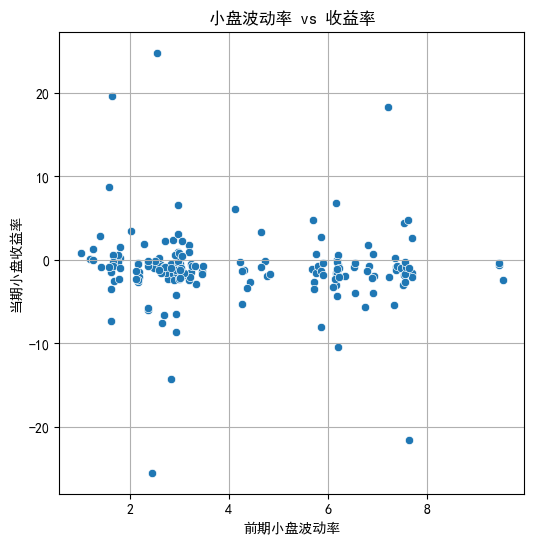

前期波动率 vs 当期收益率 相关系数: -0.0560


In [62]:
# Shift 波动率（用过去的波动率预测未来收益率）
shift_vol = small_vol.shift(1)
future_return = returns['中证1000']

# 散点图
plt.figure(figsize=(6,6))
sns.scatterplot(x=shift_vol, y=future_return)
plt.xlabel('前期小盘波动率')
plt.ylabel('当期小盘收益率')
plt.title('小盘波动率 vs 收益率')
plt.grid(True)
plt.show()

# 相关系数
corr = shift_vol.corr(future_return)
print(f"前期波动率 vs 当期收益率 相关系数: {corr:.4f}")

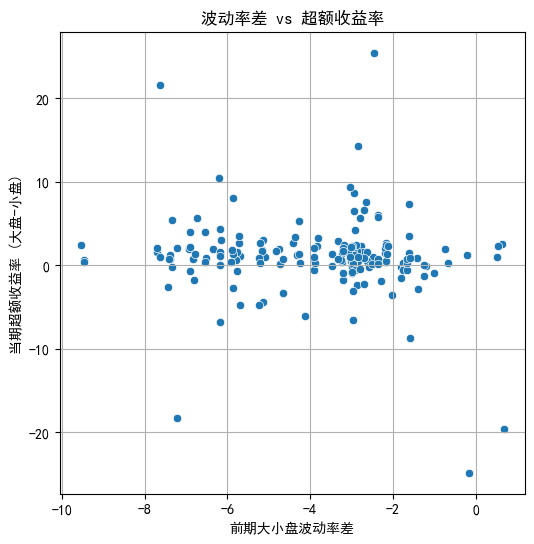

前期波动率差 vs 当期超额收益率 相关系数: -0.1133


In [63]:
# 超额收益率
excess = returns['上证50'] - returns['中证1000']

# Shift 波动率差
vol_diff_shift = vol_diff.shift(1)

# 散点图
plt.figure(figsize=(6,6))
sns.scatterplot(x=vol_diff_shift, y=excess)
plt.xlabel('前期大小盘波动率差')
plt.ylabel('当期超额收益率 (大盘-小盘)')
plt.title('波动率差 vs 超额收益率')
plt.grid(True)
plt.show()

# 相关系数
corr = vol_diff_shift.corr(excess)
print(f"前期波动率差 vs 当期超额收益率 相关系数: {corr:.4f}")

就eda的结果来看，超跌反弹和高波机会的效果应该都不会太好
大盘和小盘收益率分布虽然 厚尾，但极端负收益样本很少，出现频率低，难以提供稳定的交易机会。超额收益率（大盘-小盘）的 ACF 自相关很低 ➔ 缺乏均值回归特征，难以预测。
而从波动率 vs 收益率散点图来看，二者无明显线性关系，即使在小盘波动率极高时，收益率表现亦不稳定。
从大小盘波动率差 vs 超额收益率来看，二者关系弱，无法直接作为预测指标。

后续会尝试超跌反弹和高波机会，看结果与eda结论是否一致

## 超跌反弹

In [64]:
def backtest_dynamic_strategy_with_rebound(monthly_returns, lookback_window,
                                           start_date=None, end_date=None,
                                           weights=np.arange(0.1, 1.0, 0.1),
                                           drop_threshold=0.05,  # 超跌阈值
                                           rebound_adjustment=0.05):  # 超跌调整幅度
    results = []
    
    # 筛选日期范围
    if start_date:
        monthly_returns = monthly_returns[monthly_returns.index >= start_date]
    if end_date:
        monthly_returns = monthly_returns[monthly_returns.index <= end_date]
    
    for i in range(lookback_window, len(monthly_returns)):
        window_data = monthly_returns.iloc[i - lookback_window:i]
        
        avg_returns = []
        for w in weights:
            combined = window_data.iloc[:, 0] * w + window_data.iloc[:, 1] * (1 - w)
            avg_returns.append(combined.mean())
        
        max_idx = np.argmax(avg_returns)
        best_weight = weights[max_idx]
        
        # 当期收益率
        large_return = monthly_returns.iloc[i, 0]
        small_return = monthly_returns.iloc[i, 1]
        
        # 应用超跌反弹规则
        # 如果大盘超跌，增加大盘配置
        if large_return < -drop_threshold:
            best_weight += rebound_adjustment
        # 如果小盘超跌，减少大盘配置（即增加小盘配置）
        if small_return < -drop_threshold:
            best_weight -= rebound_adjustment
        
        # 限制权重在 [0,1] 范围
        best_weight = min(max(best_weight, 0.0), 1.0)
        
        # 计算下月策略收益
        next_month_return = large_return * best_weight + small_return * (1 - best_weight)
        
        results.append({
            'date': monthly_returns.index[i],
            'best_weight': best_weight,
            'next_month_return': next_month_return
        })
    
    results_df = pd.DataFrame(results).set_index('date')
    results_df['cum_return'] = (1 + results_df['next_month_return']).cumprod()
    
    return results_df


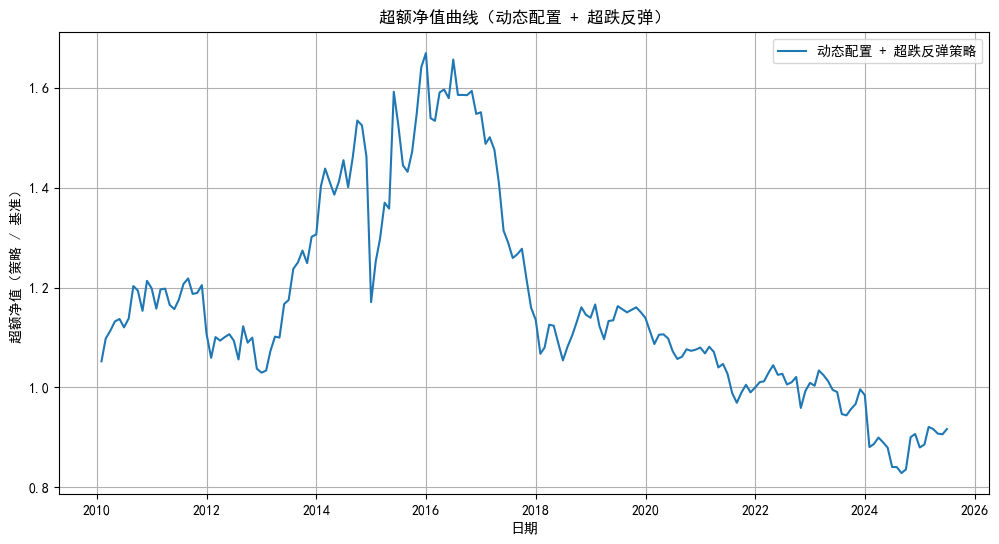

In [65]:
# 设定参数
lookback_window = 60
drop_threshold = 0.05
rebound_adjustment = 0.05

# 运行策略回测
rebound_results = backtest_dynamic_strategy_with_rebound(
    monthly_returns,
    lookback_window=lookback_window,
    drop_threshold=drop_threshold,
    rebound_adjustment=rebound_adjustment
)

# 获取基准累计净值
benchmark_returns = monthly_returns.loc[rebound_results.index, monthly_returns.columns[2]]
benchmark_cum = (1 + benchmark_returns).cumprod()

# 计算超额净值（策略 / 基准）
excess_nav = rebound_results['cum_return'] / benchmark_cum

# 绘图
plt.figure(figsize=(12,6))
plt.plot(rebound_results.index, excess_nav, label='动态配置 + 超跌反弹策略')
plt.title('超额净值曲线（动态配置 + 超跌反弹）')
plt.xlabel('日期')
plt.ylabel('超额净值（策略 / 基准）')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
def backtest_dynamic_strategy_with_rebound(monthly_returns, lookback_window, drop_threshold, rebound_adjustment, start_date=None, end_date=None, weights=np.arange(0.1, 1.0, 0.1)):
    results = []
    if start_date:
        monthly_returns = monthly_returns[monthly_returns.index >= start_date]
    if end_date:
        monthly_returns = monthly_returns[monthly_returns.index <= end_date]

    for i in range(lookback_window, len(monthly_returns)):
        window_data = monthly_returns.iloc[i-lookback_window:i]

        # 动态配置
        avg_returns = []
        for w in weights:
            combined = window_data.iloc[:,0] * w + window_data.iloc[:,1] * (1-w)
            avg_returns.append(combined.mean())
        max_idx = np.argmax(avg_returns)
        best_weight = weights[max_idx]

        # 超跌反弹
        if monthly_returns.iloc[i-1,0] < -drop_threshold:  # 大盘超跌
            best_weight = min(best_weight + rebound_adjustment, 0.9)  # 调整比例上限为0.9
        elif monthly_returns.iloc[i-1,1] < -drop_threshold:  # 小盘超跌
            best_weight = max(best_weight - rebound_adjustment, 0.1)  # 调整比例下限为0.1

        next_month_return = monthly_returns.iloc[i,0]*best_weight + monthly_returns.iloc[i,1]*(1-best_weight)

        results.append({
            'date': monthly_returns.index[i],
            'best_weight': best_weight,
            'next_month_return': next_month_return
        })

    results_df = pd.DataFrame(results).set_index('date')
    results_df['cum_return'] = (1 + results_df['next_month_return']).cumprod()

    # 计算基准净值（中证800）
    benchmark = monthly_returns.iloc[lookback_window:,2]
    benchmark_cum = (1 + benchmark).cumprod()

    # 计算超额净值
    excess_nav = results_df['cum_return'].values[-1] / benchmark_cum.values[-1]

    return excess_nav, results_df

# 参数搜索
drop_thresholds = [0.03, 0.05, 0.07, 0.1]
rebound_adjustments = [0.03, 0.05, 0.07, 0.1]

results_table = []

for drop_thres, rebound_adj in itertools.product(drop_thresholds, rebound_adjustments):
    excess_nav, res_df = backtest_dynamic_strategy_with_rebound(
        monthly_returns,
        lookback_window=60,  # 使用之前最优lookback_window
        drop_threshold=drop_thres,
        rebound_adjustment=rebound_adj,
        start_date='2005-01-01',
        end_date='2025-12-31'
    )
    results_table.append({
        'drop_threshold': drop_thres,
        'rebound_adjustment': rebound_adj,
        'excess_nav': excess_nav
    })
    print(f"阈值 {drop_thres:.2f}, 调整幅度 {rebound_adj:.2f} -> 超额净值 {excess_nav:.4f}")

# 输出结果表格
results_df = pd.DataFrame(results_table)
print("\n=== 超参数搜索结果 ===")
print(results_df.sort_values(by='excess_nav', ascending=False))


阈值 0.03, 调整幅度 0.03 -> 超额净值 1.0637
阈值 0.03, 调整幅度 0.05 -> 超额净值 1.0592
阈值 0.03, 调整幅度 0.07 -> 超额净值 1.0548
阈值 0.03, 调整幅度 0.10 -> 超额净值 1.0480
阈值 0.05, 调整幅度 0.03 -> 超额净值 1.0673
阈值 0.05, 调整幅度 0.05 -> 超额净值 1.0652
阈值 0.05, 调整幅度 0.07 -> 超额净值 1.0631
阈值 0.05, 调整幅度 0.10 -> 超额净值 1.0599
阈值 0.07, 调整幅度 0.03 -> 超额净值 1.0777
阈值 0.07, 调整幅度 0.05 -> 超额净值 1.0827
阈值 0.07, 调整幅度 0.07 -> 超额净值 1.0876
阈值 0.07, 调整幅度 0.10 -> 超额净值 1.0949
阈值 0.10, 调整幅度 0.03 -> 超额净值 1.0743
阈值 0.10, 调整幅度 0.05 -> 超额净值 1.0770
阈值 0.10, 调整幅度 0.07 -> 超额净值 1.0797
阈值 0.10, 调整幅度 0.10 -> 超额净值 1.0838

=== 超参数搜索结果 ===
    drop_threshold  rebound_adjustment  excess_nav
11            0.07                0.10    1.094891
10            0.07                0.07    1.087594
15            0.10                0.10    1.083765
9             0.07                0.05    1.082686
14            0.10                0.07    1.079743
8             0.07                0.03    1.077745
13            0.10                0.05    1.077050
12            0.10             

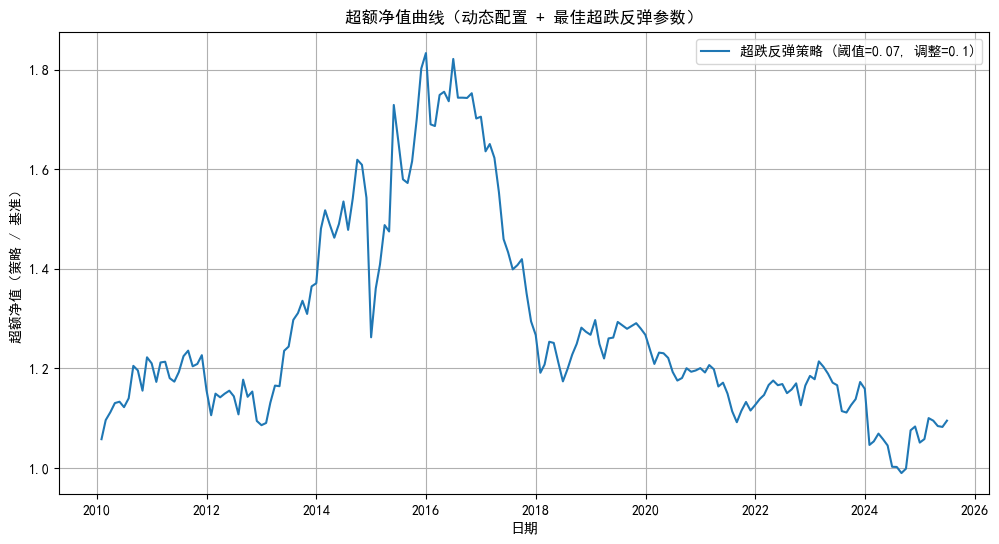

In [68]:
# 使用最佳参数回测
best_drop_threshold = 0.07
best_rebound_adjustment = 0.10

excess_nav, best_result_df = backtest_dynamic_strategy_with_rebound(
    monthly_returns,
    lookback_window=60,
    drop_threshold=best_drop_threshold,
    rebound_adjustment=best_rebound_adjustment,
    start_date='2005-01-01',
    end_date='2025-12-31'
)

# 计算基准净值
benchmark_returns = monthly_returns.loc[best_result_df.index, monthly_returns.columns[2]]
benchmark_cum = (1 + benchmark_returns).cumprod()

# 计算超额净值 = 策略净值 / 基准净值
excess_nav_series = best_result_df['cum_return'] / benchmark_cum

# 绘图
plt.figure(figsize=(12,6))
plt.plot(excess_nav_series.index, excess_nav_series, label=f"超跌反弹策略 (阈值={best_drop_threshold}, 调整={best_rebound_adjustment})")
plt.title("超额净值曲线（动态配置 + 最佳超跌反弹参数）")
plt.xlabel("日期")
plt.ylabel("超额净值（策略 / 基准）")
plt.legend()
plt.grid(True)
plt.show()


超跌反弹作为附加规则并未显著增强策略表现，说明大盘和小盘超跌后没有明显且稳定的反弹机会，至少目前的样本和参数范围下，并不具备较强的均值回归特性。
这与eda的结论一致

### 高波机会

In [88]:
monthly_returns['中证1000全收益']

date
2005-01-31         NaN
2005-02-28    0.113851
2005-03-31   -0.144244
2005-04-30   -0.088453
2005-05-31   -0.031163
                ...   
2025-02-28    0.072599
2025-03-31   -0.006961
2025-04-30   -0.044030
2025-05-31    0.015690
2025-06-30    0.046009
Freq: ME, Name: 中证1000全收益, Length: 246, dtype: float64

In [89]:
# 计算波动率
window = 12
returns = monthly_returns['中证1000全收益']
volatility = returns.rolling(window).std()

# 定义高波动
vol_mean = volatility.mean()
high_vol = volatility > (vol_mean * 1.5)

# 构建DataFrame
df = pd.DataFrame({
    'return': returns,
    'volatility': volatility,
    'high_vol': high_vol
})

# shift计算次月收益率
df['next_month_return'] = df['return'].shift(-1)

# 高波动 + 当月上涨
up_condition = (df['high_vol']) & (df['return'] > 0)
print("高波动+上涨次月平均收益率:", df.loc[up_condition, 'next_month_return'].mean())

# 高波动 + 当月下跌
down_condition = (df['high_vol']) & (df['return'] < 0)
print("高波动+下跌次月平均收益率:", df.loc[down_condition, 'next_month_return'].mean())

高波动+上涨次月平均收益率: 0.0064810908538469976
高波动+下跌次月平均收益率: 0.020666553018700705


In [90]:
# 非高波条件
non_high_vol = ~df['high_vol']

# 计算非高波 + 上涨
up_nonhigh = (non_high_vol) & (df['return'] > 0)
print("非高波 + 上涨 次月平均收益：", df.loc[up_nonhigh, 'next_month_return'].mean())

# 计算非高波 + 下跌
down_nonhigh = (non_high_vol) & (df['return'] < 0)
print("非高波 + 下跌 次月平均收益：", df.loc[down_nonhigh, 'next_month_return'].mean())

非高波 + 上涨 次月平均收益： 0.020771570216612387
非高波 + 下跌 次月平均收益： 0.0027516142468403874


In [92]:
monthly_returns

,50收益,中证1000全收益,800收益
date,,,
2005-01-31,NaN,NaN,NaN
2005-02-28,0.067751,0.113851,0.094154
2005-03-31,-0.084268,-0.144244,-0.102051
2005-04-30,-0.006853,-0.088453,-0.022693
2005-05-31,-0.068857,-0.031163,-0.075721
...,...,...,...
2025-02-28,0.021406,0.072599,0.026608
2025-03-31,0.010109,-0.006961,-0.000559
2025-04-30,-0.011117,-0.044030,-0.031148


In [93]:
# 计算波动率
window = 12
returns = monthly_returns['50收益']
volatility = returns.rolling(window).std()

# 定义高波动
vol_mean = volatility.mean()
high_vol = volatility > (vol_mean * 1.5)

# 构建DataFrame
df = pd.DataFrame({
    'return': returns,
    'volatility': volatility,
    'high_vol': high_vol
})

# shift计算次月收益率
df['next_month_return'] = df['return'].shift(-1)

# 高波动 + 当月上涨
up_condition = (df['high_vol']) & (df['return'] > 0)
print("【大盘】高波动 + 上涨 次月平均收益率:", df.loc[up_condition, 'next_month_return'].mean())

# 高波动 + 当月下跌
down_condition = (df['high_vol']) & (df['return'] < 0)
print("【大盘】高波动 + 下跌 次月平均收益率:", df.loc[down_condition, 'next_month_return'].mean())

# 非高波动 + 上涨
non_high_vol = ~df['high_vol']
up_nonhigh = (non_high_vol) & (df['return'] > 0)
print("【大盘】非高波动 + 上涨 次月平均收益率:", df.loc[up_nonhigh, 'next_month_return'].mean())

# 非高波动 + 下跌
down_nonhigh = (non_high_vol) & (df['return'] < 0)
print("【大盘】非高波动 + 下跌 次月平均收益率:", df.loc[down_nonhigh, 'next_month_return'].mean())


【大盘】高波动 + 上涨 次月平均收益率: 0.02041477304032453
【大盘】高波动 + 下跌 次月平均收益率: -0.030729526525708054
【大盘】非高波动 + 上涨 次月平均收益率: 0.012775178806577865
【大盘】非高波动 + 下跌 次月平均收益率: 0.01382073672815532


In [96]:
def backtest_high_vol_opportunity_adjusted(monthly_returns, window=12, vol_multiplier=1.5,
                                           big_adjustment=0.1, small_adjustment=0.1,
                                           baseline_big=0.5, baseline_small=0.5):
    """
    高波动机会策略（大小盘仓位总和=1）：
    - 大盘高波动+下跌：大盘 += big_adjustment，小盘 -= big_adjustment
    - 大盘高波动+上涨：大盘 -= big_adjustment，小盘 += big_adjustment
    - 小盘高波动：小盘 -= small_adjustment，大盘 += small_adjustment
    - 无高波动：baseline
    """
    returns = monthly_returns.copy()
    
    # 计算波动率
    volatility_big = returns['50收益'].rolling(window).std()
    volatility_small = returns['中证1000全收益'].rolling(window).std()
    
    vol_mean_big = volatility_big.mean()
    vol_mean_small = volatility_small.mean()
    
    high_vol_big = volatility_big > (vol_mean_big * vol_multiplier)
    high_vol_small = volatility_small > (vol_mean_small * vol_multiplier)
    
    # 初始化仓位 baseline
    big_weight = pd.Series(baseline_big, index=returns.index)
    small_weight = pd.Series(baseline_small, index=returns.index)
    
    # 大盘条件
    up_big = (high_vol_big) & (returns['50收益'] > 0)
    down_big = (high_vol_big) & (returns['50收益'] < 0)
    
    # 小盘条件
    high_small = high_vol_small
    
    # 调整
    big_weight[down_big] += big_adjustment
    small_weight[down_big] -= big_adjustment
    
    big_weight[up_big] -= big_adjustment
    small_weight[up_big] += big_adjustment
    
    big_weight[high_small] += small_adjustment
    small_weight[high_small] -= small_adjustment
    
    # clip 防止出现负权重或超1
    big_weight = big_weight.clip(0,1)
    small_weight = 1 - big_weight
    
    # 计算组合收益
    strat_returns = returns['50收益'] * big_weight + returns['中证1000全收益'] * small_weight
    cum_return = (1 + strat_returns).cumprod()
    
    return cum_return, strat_returns, big_weight, small_weight

In [100]:
cum_return, strat_returns, big_weight, small_weight = backtest_high_vol_opportunity_adjusted(monthly_returns)

# === 【E. 输出策略表现统计】 ===
print(f"年化收益率: {(cum_return.iloc[-1] ** (12/len(cum_return)) - 1):.2%}")
print(f"累计收益: {cum_return.iloc[-1]:.2f}")
print(f"年化波动率: {strat_returns.std() * (12 ** 0.5):.2%}")
print(f"夏普比率: {(strat_returns.mean() / strat_returns.std()) * (12 ** 0.5):.2f}")

年化收益率: 10.14%
累计收益: 7.24
年化波动率: 27.57%
夏普比率: 0.49


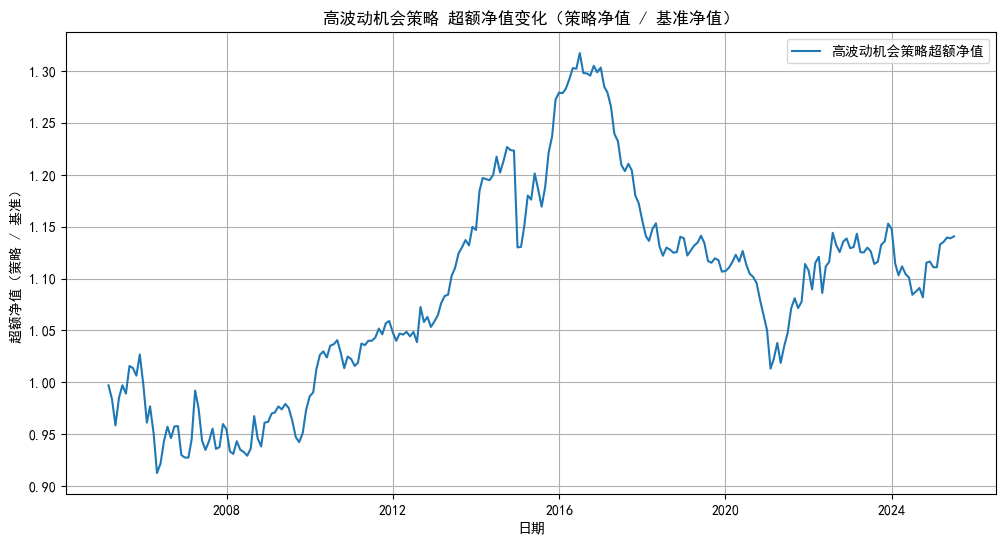

In [99]:
# 计算基准累计净值
benchmark_cum_return = (1 + monthly_returns['800收益']).cumprod()

# 计算超额净值
excess_nav = cum_return / benchmark_cum_return

# 绘制超额净值变化图
plt.figure(figsize=(12,6))
plt.plot(excess_nav.index, excess_nav.values, label='高波动机会策略超额净值')
plt.title('高波动机会策略 超额净值变化（策略净值 / 基准净值）')
plt.xlabel('日期')
plt.ylabel('超额净值（策略 / 基准）')
plt.legend()
plt.grid(True)
plt.show()


加入动态权重调整

In [101]:
def backtest_high_vol_opportunity_dynamic_adjustment(monthly_returns, window=12, vol_multiplier=1.5,
                                                     base_big_adjustment=0.1, base_small_adjustment=0.1,
                                                     baseline_big=0.5, baseline_small=0.5,
                                                     max_adjustment=0.3):
    """
    高波动机会动态调整策略：
    - 大盘高波动+下跌：大盘 += 动态调整，小盘 -= 动态调整
    - 大盘高波动+上涨：大盘 -= 动态调整，小盘 += 动态调整
    - 小盘高波动：小盘 -= 动态调整，大盘 += 动态调整
    - 无高波动：baseline

    调整幅度 = base_adjustment * (当前波动率 / 均值波动率 - 1)，clip到0-max_adjustment
    """

    returns = monthly_returns.copy()

    # === 计算波动率 ===
    volatility_big = returns['50收益'].rolling(window).std()
    volatility_small = returns['中证1000全收益'].rolling(window).std()

    vol_mean_big = volatility_big.mean()
    vol_mean_small = volatility_small.mean()

    high_vol_big = volatility_big > (vol_mean_big * vol_multiplier)
    high_vol_small = volatility_small > (vol_mean_small * vol_multiplier)

    # === 计算动态调整比例因子 ===
    big_vol_factor = (volatility_big / vol_mean_big - 1).clip(lower=0)
    small_vol_factor = (volatility_small / vol_mean_small - 1).clip(lower=0)

    # 动态调整 = base_adjustment * vol_factor，限制在0-max_adjustment
    big_adjustment_dynamic = (base_big_adjustment * big_vol_factor).clip(0, max_adjustment)
    small_adjustment_dynamic = (base_small_adjustment * small_vol_factor).clip(0, max_adjustment)

    # === 初始化仓位 baseline ===
    big_weight = pd.Series(baseline_big, index=returns.index)
    small_weight = pd.Series(baseline_small, index=returns.index)

    # === 大盘条件 ===
    up_big = (high_vol_big) & (returns['50收益'] > 0)
    down_big = (high_vol_big) & (returns['50收益'] < 0)

    # === 小盘条件 ===
    high_small = high_vol_small

    # === 调整仓位 ===
    big_weight[down_big] += big_adjustment_dynamic[down_big]
    small_weight[down_big] -= big_adjustment_dynamic[down_big]

    big_weight[up_big] -= big_adjustment_dynamic[up_big]
    small_weight[up_big] += big_adjustment_dynamic[up_big]

    big_weight[high_small] += small_adjustment_dynamic[high_small]
    small_weight[high_small] -= small_adjustment_dynamic[high_small]

    # === clip 防止出现负权重或超1 ===
    big_weight = big_weight.clip(0, 1)
    small_weight = 1 - big_weight

    # === 计算组合收益 ===
    strat_returns = returns['50收益'] * big_weight + returns['中证1000全收益'] * small_weight
    cum_return = (1 + strat_returns).cumprod()

    return cum_return, strat_returns, big_weight, small_weight

In [102]:
# === 调用修改后的策略函数 ===
cum_return, strat_returns, big_weight, small_weight = backtest_high_vol_opportunity_dynamic_adjustment(monthly_returns)

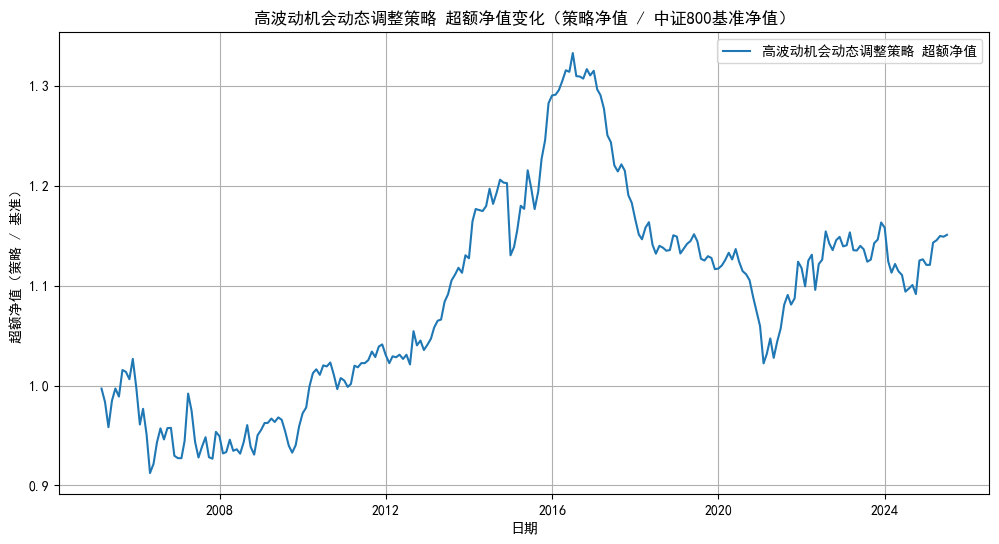

In [106]:
# 计算基准净值（中证800）
benchmark_return = monthly_returns['800收益']
benchmark_cum = (1 + benchmark_return).cumprod()

# 计算超额净值
excess_nav = cum_return / benchmark_cum

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav.index, excess_nav.values, label='高波动机会动态调整策略 超额净值')
plt.title('高波动机会动态调整策略 超额净值变化（策略净值 / 中证800基准净值）')
plt.xlabel('日期')
plt.ylabel('超额净值（策略 / 基准）')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# 计算年化收益率
annual_ret = (cum_return.iloc[-1] ** (12/len(cum_return)) - 1)

# 计算年化波动率
annual_vol = strat_returns.std() * (12 ** 0.5)

# 计算夏普比率
sharpe_ratio = strat_returns.mean() / strat_returns.std() * (12 ** 0.5)

print(f"年化收益率: {annual_ret:.2%}")
print(f"累计收益: {cum_return.iloc[-1]:.2f}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")

年化收益率: 10.18%
累计收益: 7.30
年化波动率: 27.61%
夏普比率: 0.49


## 全仓小盘

In [107]:
cum_return_small = (1 + monthly_returns['中证1000全收益']).cumprod()

In [108]:
monthly_returns

,50收益,中证1000全收益,800收益
date,,,
2005-01-31,NaN,NaN,NaN
2005-02-28,0.067751,0.113851,0.094154
2005-03-31,-0.084268,-0.144244,-0.102051
2005-04-30,-0.006853,-0.088453,-0.022693
2005-05-31,-0.068857,-0.031163,-0.075721
...,...,...,...
2025-02-28,0.021406,0.072599,0.026608
2025-03-31,0.010109,-0.006961,-0.000559
2025-04-30,-0.011117,-0.044030,-0.031148


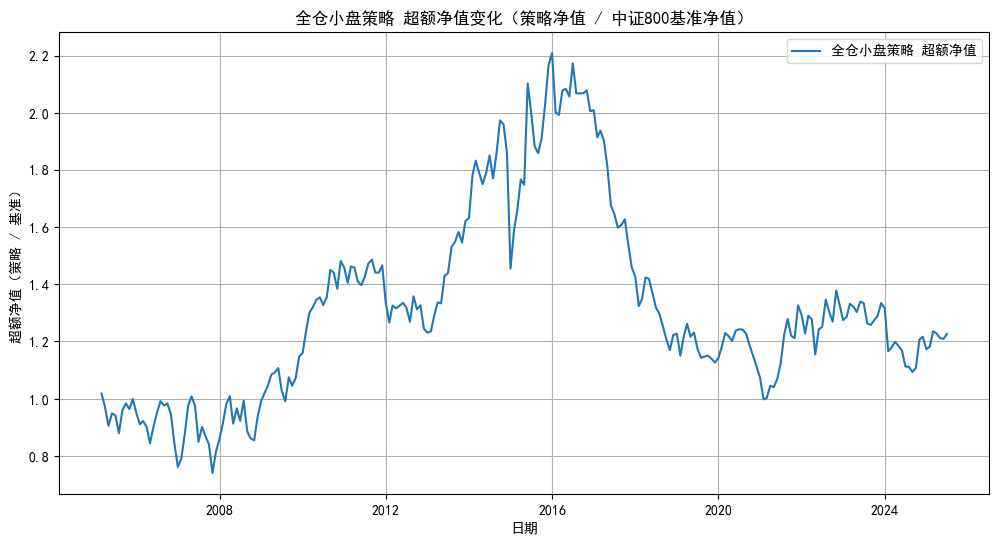

In [109]:
# 计算全仓小盘策略净值
small_returns = monthly_returns['中证1000全收益']
cum_small = (1 + small_returns).cumprod()

# 计算基准净值（假设为中证800）
benchmark_returns = monthly_returns['800收益']
cum_bench = (1 + benchmark_returns).cumprod()

# 计算超额净值（策略 / 基准）
excess_nav = cum_small / cum_bench

# 画图
plt.figure(figsize=(12,6))
plt.plot(excess_nav.index, excess_nav.values, label='全仓小盘策略 超额净值')
plt.title('全仓小盘策略 超额净值变化（策略净值 / 中证800基准净值）')
plt.xlabel('日期')
plt.ylabel('超额净值（策略 / 基准）')
plt.legend()
plt.grid(True)
plt.show()